In [16]:
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [3]:
CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4096,
    'SEED':41
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [11]:
train_data = pd.read_csv('./train3.csv').drop(columns=['ID', '제품'])
train_data.head()

,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,2,0,2,0,2,2,1,0,0,0
2,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00010,0,0,0,0,0,...,10,6,4,4,4,0,0,0,0,8


In [12]:
train_data

,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,2,0,2,0,2,2,1,0,0,0
2,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00010,0,0,0,0,0,...,10,6,4,4,4,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28889,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28890,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28891,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,0,0,...,2,4,1,0,0,0,4,0,2,0
28892,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
condition = train_data['소분류'] == 'c002-C003-0041'

for date in pd.date_range('2022-10-03', '2022-10-07').strftime('%Y-%m-%d'):
    train_data.loc[condition, date] = train_data.loc[condition, '2022-10-01'].values

sorted_columns = sorted([str(col).split()[0] for col in train_data.columns if '-' in str(col)])
train_data = train_data[["대분류", "중분류", "소분류", "브랜드"] + sorted_columns]

train_data[train_data['소분류'] == 'B002-C003-0041'].loc[:, '2022-09-30':'2022-10-08']

,2022-09-30,2022-10-01,2022-10-02,2022-10-03,2022-10-04,2022-10-05,2022-10-06,2022-10-07,2022-10-08
51,0,0,0,0,0,0,0,0,0
1320,0,2,0,0,0,0,0,0,0
3669,0,0,0,0,0,0,0,0,0
3670,0,0,0,0,0,0,0,0,0
3873,228,0,0,0,0,456,0,912,0
...,...,...,...,...,...,...,...,...,...
25363,0,0,0,0,0,0,0,0,0
25364,0,0,0,0,0,0,0,0,0
25650,0,0,0,0,0,0,0,32,64
26724,18,0,0,0,8,8,14,18,0


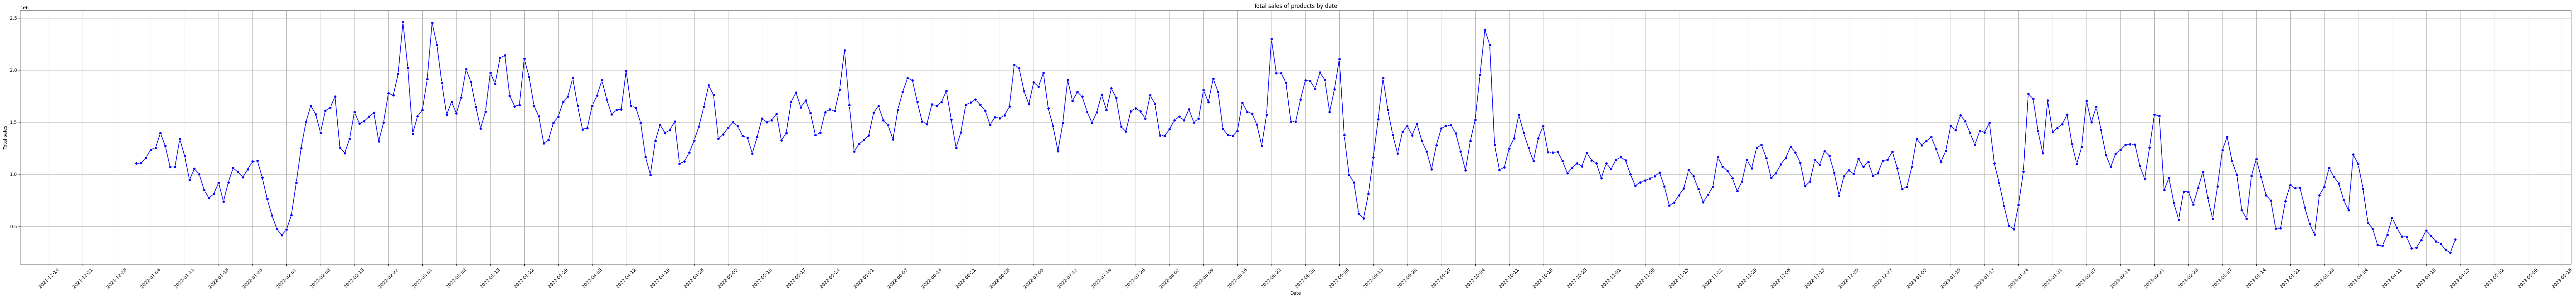

In [18]:
sales_date_melted = pd.melt(
    train_data,
    id_vars = ['대분류', '중분류', '소분류', '브랜드'],
    var_name = '날짜',
    value_name = '판매량'
)

sales_date_melted['날짜'] = pd.to_datetime(sales_date_melted['날짜'])
daily_total_sales = sales_date_melted.groupby('날짜')['판매량'].sum().reset_index()

plt.figure(figsize = (100, 10))
sns.lineplot(data = daily_total_sales, x = '날짜',  y = '판매량', marker = 'o', color = 'b')
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.title('Total sales of products by date')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval = 1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid()


In [ ]:
# 먼저 5번째 열부터의 데이터만 선택합니다.
data_subset = train_data.iloc[:, 5:]

# 각 행의 최댓값과 최솟값을 계산합니다.
max_values = data_subset.max(axis=1)
min_values = data_subset.min(axis=1)

# 분모가 0이 되는 경우를 처리하기 위해 조건을 적용합니다.
diff = max_values - min_values
mask = diff != 0

# 정규화 작업을 수행합니다.
train_data.loc[mask, data_subset.columns] = (data_subset[mask] - min_values[mask].values.reshape(-1, 1)) / diff[mask].values.reshape(-1, 1)
train_data.loc[~mask, data_subset.columns] = 0

# 결과를 사전에 저장합니다.
scale_max_dict = max_values.to_dict()
scale_min_dict = min_values.to_dict()

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드', '쇼핑몰']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE'], is_inference=False):
        self.data = data.values
        self.train_size = train_size
        self.predict_size = predict_size
        self.window_size = self.train_size + self.predict_size
        self.is_inference = is_inference

    def __len__(self):
        if self.is_inference:
            return len(self.data)
        else:
            return self.data.shape[0] * (self.data.shape[1] - self.window_size - 4)

    def __getitem__(self, idx):
        if self.is_inference:
            encode_info = self.data[idx, :5]
            window = self.data[idx, -self.train_size:]
            input_data = np.column_stack((np.tile(encode_info, (self.train_size, 1)), window))
            input_data = torch.Tensor(input_data)  # Convert to tensor
            return input_data
        else:
            row = idx // (self.data.shape[1] - self.window_size - 4)
            col = idx % (self.data.shape[1] - self.window_size - 4)
            encode_info = self.data[row, :5]
            sales_data = self.data[row, 5:]
            window = sales_data[col : col + self.window_size]
            input_data = np.column_stack((np.tile(encode_info, (self.train_size, 1)), window[:self.train_size]))
            target_data = window[self.train_size:]
            input_data = torch.Tensor(input_data)  # Convert to tensor
            target_data = torch.Tensor(target_data)  # Convert to tensor
            return input_data, target_data

In [ ]:
# Create an instance of CustomDataset
dataset = CustomDataset(train_data)

# Calculate the total size of the dataset
total_size = len(dataset)

# Calculate the sizes of the split datasets
train_size = int(total_size * 0.8)
val_size = total_size - train_size

# Use random_split function to split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, input_size=6, hidden_size=1024, output_size=CFG['PREDICT_SIZE'], num_layers=3, dropout=0.3):
        super(BaseModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size // 2, output_size)
        )

        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        lstm_out, hidden = self.lstm(x, hidden)

        last_output = lstm_out[:, -1, :]

        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))

In [ ]:
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.float().to(device)
            Y = Y.float().to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.float().to(device)
            Y = Y.float().to(device)

            output = model(X)
            loss = criterion(output, Y)

            val_loss.append(loss.item())
    return np.mean(val_loss)

In [ ]:
model = BaseModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)